In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

# Intialize Plots w/ default fig width/height
try
  fig_width = 7
  fig_height = 5
  fig_format = :retina
  fig_dpi = 96
  # no retina format type, use svg for high quality type/marks
  if fig_format == :retina
    fig_format = :svg
  # IJulia doesn't support PDF output so use png (if the DPI 
  # remains the default of 300 then set to 96)
  elseif fig_format == :pdf
    fig_format = :png
    fig_dpi = 96
  end
  # convert inches to pixels
  fig_width = fig_width * fig_dpi
  fig_height = fig_height * fig_dpi
  using Plots
  gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| code-fold: false
using VPL

module Queries
    using VPL
    struct A <: Node end

    struct C <: Node
        val::Float64
    end

    struct B <: Node
        ID::Int
    end
end
import .Queries as Q

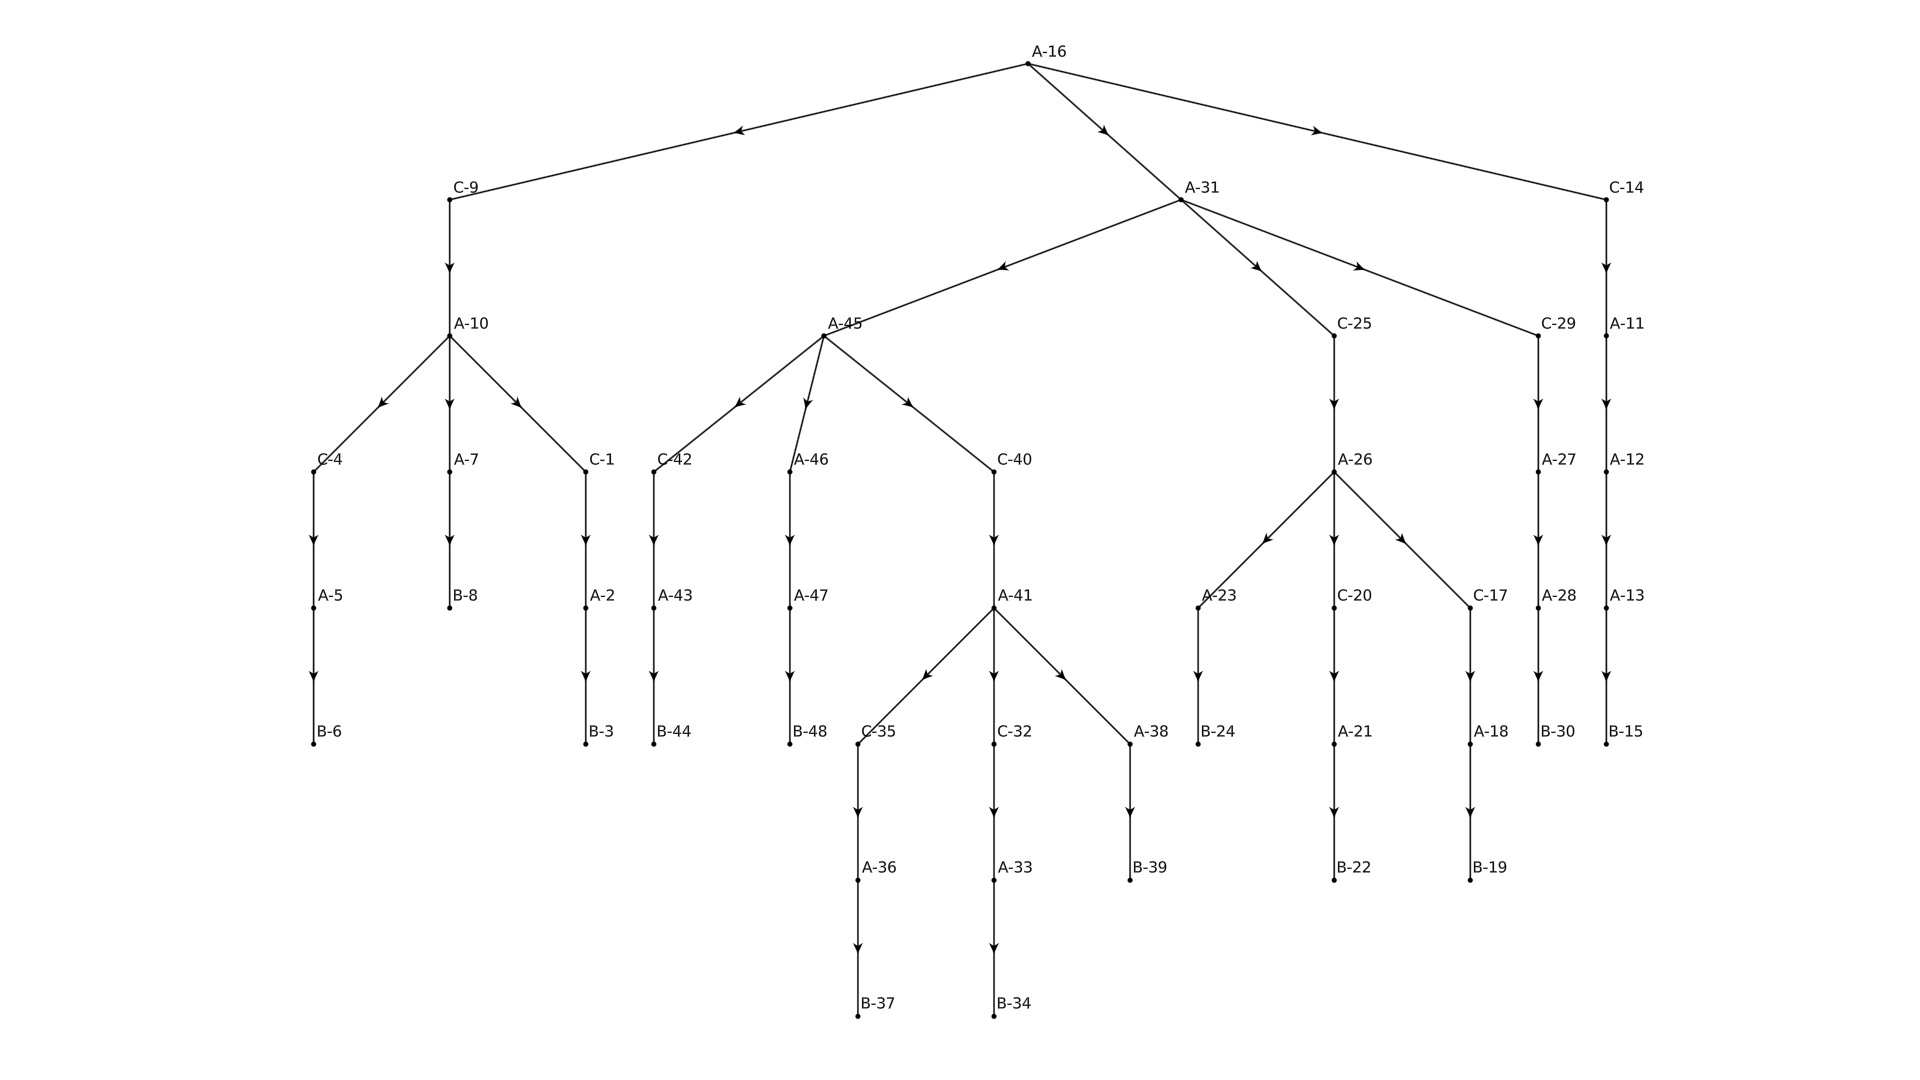

In [3]:
#| code-fold: false
motif(n, i = 0) = Q.A() + (Q.C(45.0) + Q.A() + (Q.C(45.0) +  Q.A() + Q.B(i + 1), 
                                           Q.C(-45.0) + Q.A() + Q.B(i + 2), 
                                                       Q.A() + Q.B(i + 3)), 
                         Q.C(- 45.0) + sum(Q.A() for i in 1:n) + Q.B(i + 4))
axiom =  motif(3, 0) + motif(2, 4) + motif(1, 8) + Q.A() + Q.A() + Q.B(13)
graph = Graph(axiom);
draw(graph)

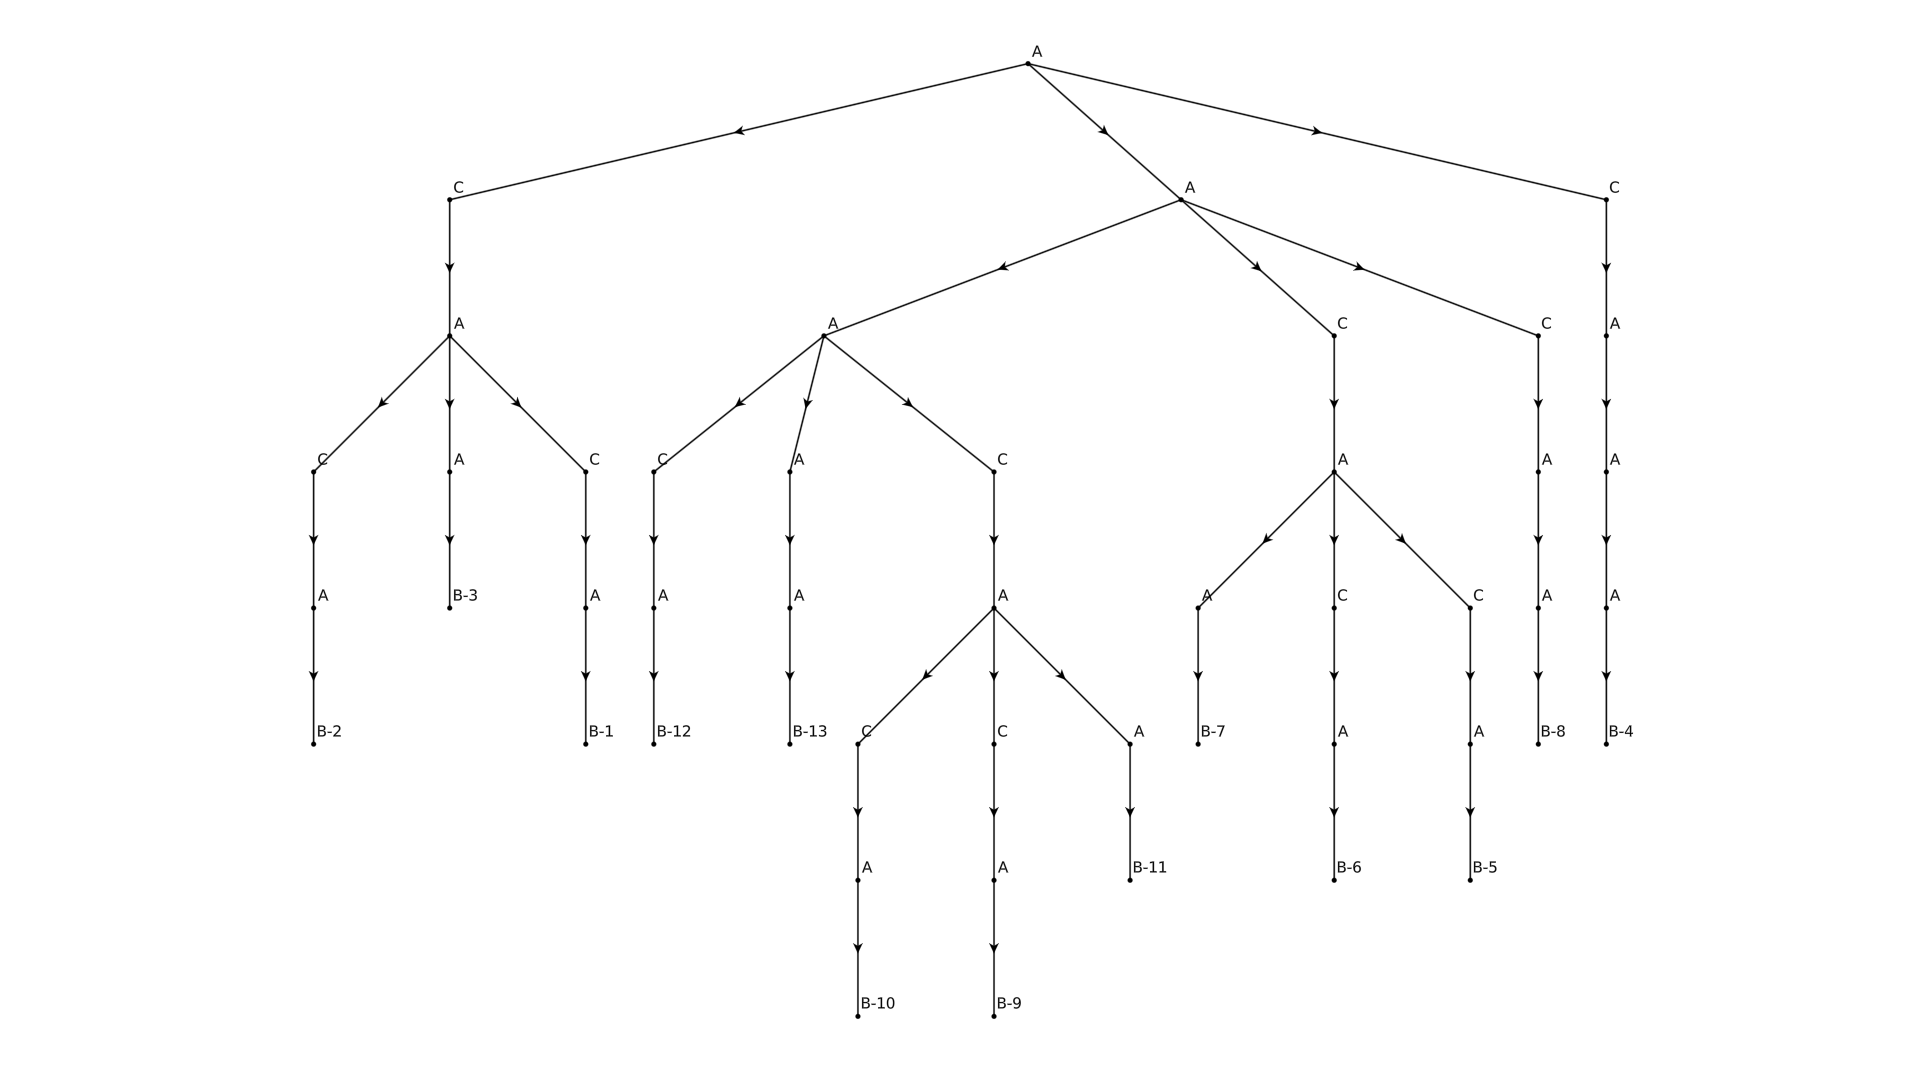

In [4]:
VPL.node_label(n::Q.B, id) = "B-$(n.ID)"
VPL.node_label(n::Q.A, id) = "A"
VPL.node_label(n::Q.C, id) = "C"
draw(graph)

In [5]:
#| code-fold: false
Q1 = Query(Q.B)

Query object for nodes of type Main.Queries.B


In [6]:
#| code-fold: false
A1 = apply(graph, Q1)

13-element Vector{Main.Queries.B}:
 Main.Queries.B(7)
 Main.Queries.B(8)
 Main.Queries.B(3)
 Main.Queries.B(10)
 Main.Queries.B(5)
 Main.Queries.B(6)
 Main.Queries.B(2)
 Main.Queries.B(12)
 Main.Queries.B(1)
 Main.Queries.B(11)
 Main.Queries.B(13)
 Main.Queries.B(9)
 Main.Queries.B(4)

In [7]:
function Q2_fun(n)
    check, steps = hasAncestor(n, x -> data(x) isa Q.C)
    !check
end

Q2_fun (generic function with 1 method)

In [8]:
Q2 = Query(Q.B, Q2_fun)
A2 = apply(graph, Q2)

1-element Vector{Main.Queries.B}:
 Main.Queries.B(13)

In [9]:
function branch_motif(p)
    data(p) isa Q.A && 
    hasDescendent(p, x -> data(x) isa Q.C && data(x).val < 0.0) &&
    hasAncestor(p, x -> data(x) isa Q.C && data(x).val > 0.0)[1]
end

function Q3_fun(n, nsteps)
    # Condition 1
    check, steps = hasAncestor(n, branch_motif)
    !check && return false
    # Condition 2
    p = parent(n, steps)
    check, steps = hasAncestor(p, isRoot)
    steps != nsteps && return false
    return true
end

Q3_fun (generic function with 1 method)

In [10]:
Q3 = Query(Q.B, n -> Q3_fun(n, 2))
A3 = apply(graph, Q3)

3-element Vector{Main.Queries.B}:
 Main.Queries.B(3)
 Main.Queries.B(2)
 Main.Queries.B(1)

In [11]:
function Q4_fun(n)
    !hasAncestor(n, x -> !isRoot(x) && length(children(x)) > 1)[1]
end

Q4_fun (generic function with 1 method)

In [12]:
Q4 = Query(Q.B, Q4_fun)
A4 = apply(graph, Q4)

1-element Vector{Main.Queries.B}:
 Main.Queries.B(4)

In [13]:
function Q5_fun(n)
    check, steps = hasAncestor(n, isRoot)
    steps == 4
end

Q5 = Query(Q.B, Q5_fun)
A5 = apply(graph, Q5)

1-element Vector{Main.Queries.B}:
 Main.Queries.B(3)

In [14]:
function Q6_fun(n, nA)
    check = Q3_fun(n, nA)
    !check && return false
    p2 = parent(n,2)
    data(p2) isa Q.A
end

Q6 = Query(Q.B, n -> Q6_fun(n, 3))
A6 = apply(graph, Q6)

1-element Vector{Main.Queries.B}:
 Main.Queries.B(7)

In [15]:
Q7 = Query(Q.B, n -> Q6_fun(n, 4) || Q2_fun(n))
A7 = apply(graph, Q7)

2-element Vector{Main.Queries.B}:
 Main.Queries.B(11)
 Main.Queries.B(13)

In [16]:
function Q8_fun(n)
    p1 = parent(n)
    p2 = parent(n, 2)
    p3 = parent(n, 3)
    data(p1) isa Q.A && data(p2) isa Q.C && data(p2).val > 0.0 && data(p3) isa Q.A
end

Q8 = Query(Q.B, Q8_fun)
A8 = apply(graph, Q8)

3-element Vector{Main.Queries.B}:
 Main.Queries.B(5)
 Main.Queries.B(1)
 Main.Queries.B(9)

In [17]:
function Q9_fun(n)
    p1 = parent(n)
    p2 = parent(n, 2)
    p3 = parent(n, 3)
    p4 = parent(n, 4)
    data(p1) isa Q.A && data(p2) isa Q.C && data(p2).val < 0.0 && 
       data(p3) isa Q.A && data(p4) isa Q.C
end

Q9 = Query(Q.B, Q9_fun)
A9 = apply(graph, Q9)

3-element Vector{Main.Queries.B}:
 Main.Queries.B(10)
 Main.Queries.B(6)
 Main.Queries.B(2)

In [18]:
function Q10_fun(n)
    Q6_fun(n, 3) && return true # Check node 7
    Q9_fun(n) && hasAncestor(n, isRoot)[2] == 6 && return true # Check node 6
    hasAncestor(n, isRoot)[2] == 5 && data(parent(n, 3)) isa Q.C && return true # Check node 8 (and not 4!)
end

Q10 = Query(Q.B, Q10_fun)
A10 = apply(graph, Q10)

3-element Vector{Main.Queries.B}:
 Main.Queries.B(7)
 Main.Queries.B(8)
 Main.Queries.B(6)

In [19]:
function Q11_fun(n)
    Q5_fun(n) && return true # 3
    Q6_fun(n, 3) && return true # 7
    Q6_fun(n, 4) && return true # 11
    hasAncestor(n, isRoot)[2] == 5 && data(parent(n, 2)) isa Q.C && 
        data(parent(n, 4)) isa Q.A && return true # 12
end

Q11 = Query(Q.B, Q11_fun)
A11 = apply(graph, Q11)

4-element Vector{Main.Queries.B}:
 Main.Queries.B(7)
 Main.Queries.B(3)
 Main.Queries.B(12)
 Main.Queries.B(11)

In [20]:
function Q12_fun(n)
    Q6_fun(n, 3) && return true # 7
    hasAncestor(n, isRoot)[2] == 5 && data(parent(n, 2)) isa Q.C && 
        data(parent(n, 4)) isa Q.A && return true # 12
end

Q12 = Query(Q.B, Q12_fun)
A12 = apply(graph, Q12)

2-element Vector{Main.Queries.B}:
 Main.Queries.B(7)
 Main.Queries.B(12)